# Logistische Regression ersetzt Perzeptron


## Lernziele

```{admonition} Lernziele
:class: important
* Sie können die **logistische Funktion** zeichnen.
* Sie können die **Funktionsgleichung der logistischen Funktion** angeben.
* Sie können das **logistische Regressionsmodell** schematisch darstellen. 
```

## Perzeptron ungeeignet bei nicht trennbaren Daten

Das Perzeptron ist ein simples ML-Verfahren für die binäre Klassifikation.
Allerdings ist das Perzeptron nur für trennbare Datensätze geeignet. Dazu
schauen wir uns zwei Beispiele aus dem Männerfußball an. Ziel der folgenden
Klassifikationsaufgabe ist es, anhand des Marktwertes eines Vereines zu
klassifizieren, ob der Verein in der Bundesliga oder in der 2. Bundesliga
spielt.

Dazu laden wir als erstes den Datensatz `20220801_Marktwert_Bundesliga.csv`
(Download
[csv](https://nextcloud.frankfurt-university.de/s/GESBZzRyXq6dLNC/download);
Quelle: https://www.transfermarkt.de; Stichtag: 01.08.2022).

In [1]:
import pandas as pd
data_raw = pd.read_csv('data/20220801_Marktwert_Bundesliga.csv', skiprows=5, header=0, index_col=0)

Die ersten fünf Einträge lauten wie folgt:

In [2]:
data_raw.head()

,Ligazugehörigkeit,Wert,Kadergröße
Verein,,,
FC Bayern München,Bundesliga,870.23,28
Borussia Dortmund,Bundesliga,509.45,30
Bayer 04 Leverkusen,Bundesliga,455.35,29
RasenBallsport Leipzig,Bundesliga,486.18,30
VfL Wolfsburg,Bundesliga,239.65,33


Die erste Spalte enthält den Vereinsnamen, die zweite Spalte listet die
Ligazugehörigkeit (Bundesliga, 2. Bundesliga oder 3. Liga), die dritte Spalte
beinhaltet den Marktwert des Vereins in Mio. Euro und die vierte Spalte listet
die Anzahl der Spieler.

Zuerst erkunden wie die Daten und lassen uns die Ligazugehörigkeit abhängig vom
Marktwert visualisieren.

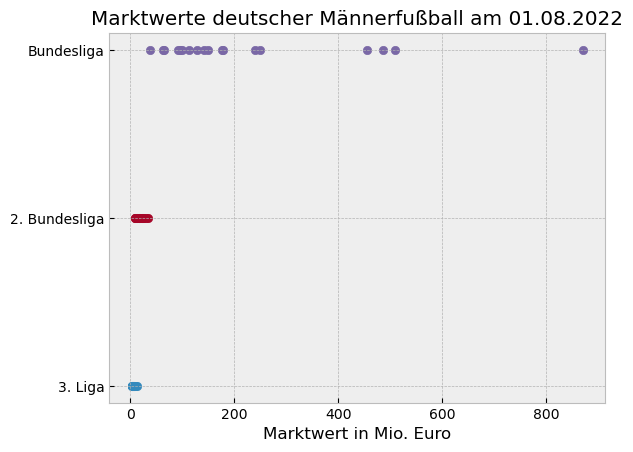

In [3]:
# teile die Datensätze nach Ligazugehörigkeit auf
data_liga1 = data_raw[data_raw['Ligazugehörigkeit'] == 'Bundesliga']
data_liga2 = data_raw[data_raw['Ligazugehörigkeit'] == '2. Bundesliga']
data_liga3 = data_raw[data_raw['Ligazugehörigkeit'] == '3. Liga']

# visualisiere Marktwert --> Ligazugehörigkeit 
import matplotlib.pylab as plt; plt.style.use('bmh')

fig, ax = plt.subplots()
ax.scatter(data_liga3['Wert'], data_liga3['Ligazugehörigkeit'])
ax.scatter(data_liga2['Wert'], data_liga2['Ligazugehörigkeit'])
ax.scatter(data_liga1['Wert'], data_liga1['Ligazugehörigkeit'])
ax.set_xlabel('Marktwert in Mio. Euro')
ax.set_title('Marktwerte deutscher Männerfußball am 01.08.2022');

Die Marktwerte der Bundesliga-Vereine sind vereinzelt so hoch, dass die
einzelnen Vereine der 3. Liga als solche kaum erkennbar sind. Wir begrenzen
daher den Marktwert auf 100 Mio. Euro.

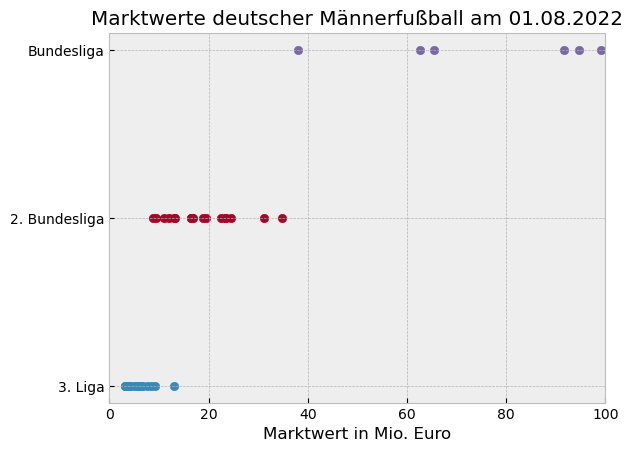

In [4]:
fig, ax = plt.subplots()
ax.scatter(data_liga3['Wert'], data_liga3['Ligazugehörigkeit'])
ax.scatter(data_liga2['Wert'], data_liga2['Ligazugehörigkeit'])
ax.scatter(data_liga1['Wert'], data_liga1['Ligazugehörigkeit'])
ax.set_xlabel('Marktwert in Mio. Euro')
ax.set_title('Marktwerte deutscher Männerfußball am 01.08.2022')
ax.set_xlim([0, 100]);

Wie erkennen, dass ein Marktwert von 36 Mio. Euro die Erstligisten von den
Zweitligisten trennt. Daher wäre für eine Klassifikation Bundesliga vs. 2.
Bundesliga ein Perzeptron trainierbar. Eine solche Trennung funktioniert bei den
Vereinen der 2. Bundesliga und der 3. Liga nicht. Wir betrachten nun nur noch 2.
und 3. Liga.

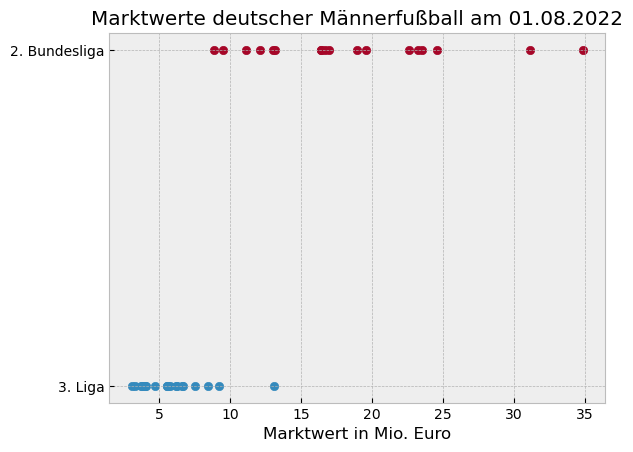

In [5]:
fig, ax = plt.subplots()
ax.scatter(data_liga3['Wert'], data_liga3['Ligazugehörigkeit'])
ax.scatter(data_liga2['Wert'], data_liga2['Ligazugehörigkeit'])
ax.set_xlabel('Marktwert in Mio. Euro')
ax.set_title('Marktwerte deutscher Männerfußball am 01.08.2022');

Als erstes ersetzen wir die Klassenbezeichnungen durch numerische Werte. Mit
Bezeichnungen wie "3. Liga" und "2. Bundesliga" kann Python nämlich nicht
rechnen. Bei einem binären Klassifikationsverfahren wie hier werden hierfür
üblicherweise die Zahlen 0 und 1 verwendet, also
<ul>
    <li>3. Liga --> 0</li>
    <li>2. Bundesliga --> 1</li>
</ul>

Das Klassifikationsproblem lautet also: angenommen, ein
Verein hat den Marktwert x. Gehört der Verein dann zur Klasse 1 (= 2.
Bundesliga)?

Als zweites verabschieden wir uns von dem Perzeptron. Anstatt eine Gerade zur
Trennung einzuziehen, nehmen wir eine S-förmige Funktion. Diese S-förmige
Funktion interpretieren wir als **Wahrscheinlichkeit** der Ligazugehörigkeit.
Die Werte liegen dabei zwischen 0 und 1. Bei einer Wahrscheinlichkeit von 1 sind
wir also 100 % sicher, dass der Verein zur Klasse 1 (= 2. Bundesliga) gehört.
Bei einem Wert von 0.7 gehen wir mit 70 % Wahrscheinlichkeit davon aus, dass der
Verein zur Klasse 1 (= 2. Bundesliga) gehört.

Als drittes verwandeln wir die Wahrscheinlichkeit mit Werten *zwischen* 0 und 1
in die Klassen 0 oder 1. Dazu nutzen wir die Heaviside-Funktion. Die komplette
Vorgehensweise ist in der folgenden Grafik dargestellt.

```{figure} pics/bundesliga_decision_function_annotated.pdf
---
width: 600px
name: bundesliga_decision_function_annotated
---
Die S-förmige schwarz gestrichelte Kurve gibt die Wahrscheinlichkeit an, dass ein Verein zur 2. Bundesliga gehört. Da nicht nach einer Wahrscheinlichkeit gefragt ist, sondern nur nach 2. Bundesliga -- ja oder nein -- werden alle Vereine mit einer Wahrscheinlichkeitgrößer 50 % (also $\geq 0.5$) als Zweitligisten klassifiziert.
```

Jetzt brauchen wir eine Funktion für die S-förmige Kurve, das wir dann mittels
eines ML-Verfahrens an unsere Trainingsdaten anpassen können.

## Logistische Funktion ersetzt Heaviside-Funktion

Beim Perzeptron wird auf die gewichtete Summe von Inputs die Heaviside-Funktion
angewandt. So simpel die Heaviside-Funktion $\phi$ auch ist, sie hat einen
entscheidenen Nachteil. Die Heaviside-Funktion ist unstetig, sie springt von
Null auf Eins. Diese Sprungstelle hat die **logistische Funktion** nicht. 

Die logistische Funktion ist defininiert als

$$\sigma(z) = \frac{1}{1+e^{-z}}.$$

Um die logistische Funktion abzukürzen, verwenden wir dabei den griechischen
Buchstaben Sigma $\sigma$, weil die logistische Funktion auch
**Sigmoid-Funktion** genannt wird. In der folgenden Abbildung ist der
Funktionsgraph der logistischen Funktion dargestellt.

```{figure} pics/plot_logit_function.pdf
---
width: 600px
name: plot_logit_function
---
Funktionsgraph der logistischen Funktion, auch Sigmoid-Funktion genannt
```

Damit haben wir die Bausteine des logistischen Regressionmodells komplettiert.
Genau wie bei der linearen Regression oder beim Perzeptron werden zuerst die
einzelnen Inputs gewichtet und aufsummiert. Auf die gewichtete Summe wird dann
die logistische Funktion als Aktivierungsfunktione angewendet. Das Ergebnis ist
die Wahrscheinlichkeit für die Klasse mit der Bezeichnung 1 (in unserem Beispiel
die Zugehörigkeit zur 2. Bundesliga). Zuletzt wird noch die Heaviside-Funktion
als Schwellenwertfunktion angewendet, um aus der Wahrscheinlichkeit eine Klasse
zu machen.

Schematisch dargestellt sieht das logistische Regressionsmodell also
folgendermaßen aus:


```{figure} pics/topology_logistic_regression.svg
---
width: 600px
name: topology_logistic_regression
---
Das logistische Regressionsmodell als neuronales Netz formuliert.
```

Mathematisch formuliert lautet das logistische Regressionsmodell folgendermaßen:

$$\hat{P} = \sigma\left(\sum_{i=0}^{N} x_i \omega_i\right) = \frac{1}{1+e^{-\sum x_i \omega_i}} 
\rightsquigarrow \hat{y} = \begin{cases} 0: & \hat{P} < 0.5 \\ 1: & \hat{P} \geq 0.5 \end{cases} $$

## Zusammenfassung und Ausblick

In diesem Abschnitt haben wir das logistische Regressionsmodell formuliert. Als
nächstes betrachten wir ein Lernverfahren, um die Gewichte des logistischen
Regressionsmodells zu erlernen.